In [2]:
%cd ..

c:\Users\Rodrigo\Documents\Projects\diffusion-planning-rl


In [3]:
%load_ext autoreload
%autoreload 2

import torch
import glob
import os
import sys
from hydra import compose, initialize
import hydra
from omegaconf import OmegaConf, SCMode

from lightning import Fabric
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


from dprl.data.utils import dotdict
from dprl.algo.autoencoder import CategoricalAutoEncoder
from dprl.data.datasets import LiberoDatasetAdapter
from dprl.data.utils import AtariTransform


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
try:
    initialize(version_base=None, config_path="../dprl/config")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base=None, config_path="../dprl/config")

cfg = compose(config_name="config", overrides=["algo=autoencoder_S"])
cfg = dotdict(OmegaConf.to_container(cfg, resolve=True, structured_config_mode=SCMode.DICT_CONFIG))

In [12]:
model_path = "autoencoder_S"

fabric = Fabric(accelerator='gpu', precision="bf16-mixed")

def get_last_checkpoint(model_path : str):
    checkpoints = glob.glob(f"checkpoints/{model_path}/*.ckp")
    checkpoint = max(checkpoints, key=os.path.getctime)
    
    model_params = torch.load(checkpoint, weights_only=True)['model']
    
    model : CategoricalAutoEncoder = CategoricalAutoEncoder.from_config(fabric, cfg.algo, eval=True)
    model.load_state_dict(model_params)
    
    return model
    
model = get_last_checkpoint(model_path)

Using bfloat16 Automatic Mixed Precision (AMP)


In [13]:
transform = AtariTransform(
        to_size=cfg.algo.encoder.in_shape[1:],
        swap_channels=True,
        num_channels=3,
        augment=False
    )

dataset = LiberoDatasetAdapter("datasets/libero_spatial",
                                slice_len=50,
                                transform=transform,
                                frameskip=1
                                )

In [14]:
def show_obs(y : torch.Tensor, frameskip : int = 10):
    if len(y.shape) == 5:
        y = y[0]
    
    y = y.cpu()
    
    trajectory_images = make_grid(y[::frameskip].flip(2), nrow=50//frameskip)
    trajectory_images = trajectory_images * 0.5 + 0.5
    
    plt.figure(figsize=(20, 2))
    plt.imshow(trajectory_images.permute(1, 2, 0))

Observations

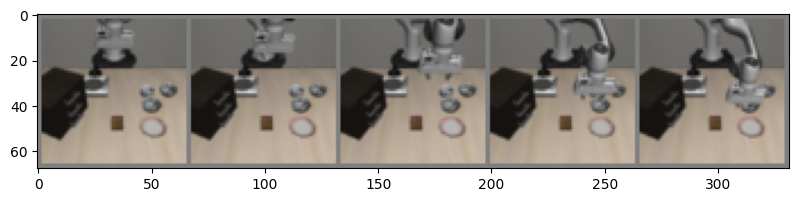

In [15]:
show_obs(dataset[0]['observations'])

Reconstructions

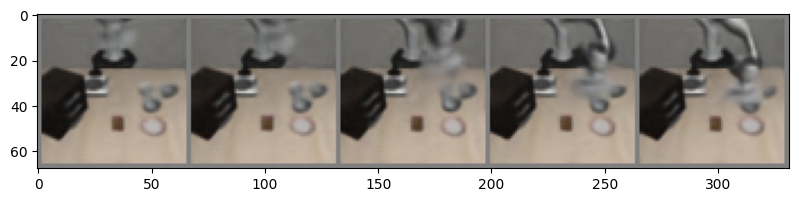

In [16]:
with torch.no_grad():
    	_, reconstructions, _ = model.generator_step(dataset[0]['observations'][None, ...].to(fabric.device))
     
show_obs(reconstructions)

Intervening

In [20]:
categoricals : torch.Tensor = model.encoder.get_categoricals(dataset[0]['observations'][None, ...].to(fabric.device))

print("Pre intervention categories")
print(categoricals[:, :].shape)
print(categoricals[0, 0].argmax(dim=-1))

Pre intervention categories
torch.Size([1, 50, 32, 16])
tensor([ 2, 12,  4, 14,  6, 13, 12,  4, 14,  2,  0,  6,  3, 15,  5, 13, 10,  2,
        13, 13, 11,  9, 11,  9, 14, 10,  3, 11, 12,  4,  4,  7],
       device='cuda:0')


Post intervention categories
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')


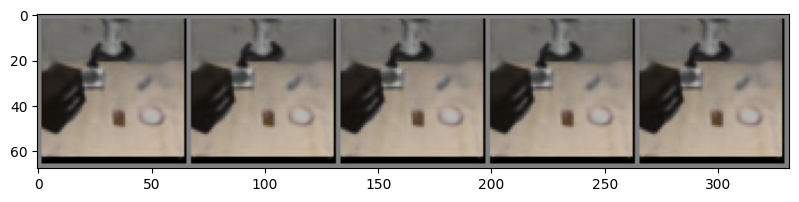

In [31]:
DIMS_TO_INTERVENE = [i for i in range(32)] # [0, num_states]
CATEGORIES_TO_FILL = [5] * 32 # [0, num_categories]

print("Post intervention categories")
categoricals = categoricals.clone()
for dim, cat in zip(DIMS_TO_INTERVENE, CATEGORIES_TO_FILL):
    categoricals[0, :, dim] = torch.nn.functional.one_hot(torch.tensor([cat], dtype=torch.long), num_classes=model.encoder.stochastic_size)
print(categoricals[0, 0].argmax(dim=-1))

latents = model.encoder.get_latents(categoricals)
with torch.inference_mode():
    reconstructions = model.decoder(latents)
    
show_obs(reconstructions)

Looking at latents

Evolution of categories along dimensions [0, 1, 2, 3, 4, 5, 6, 7, 8]


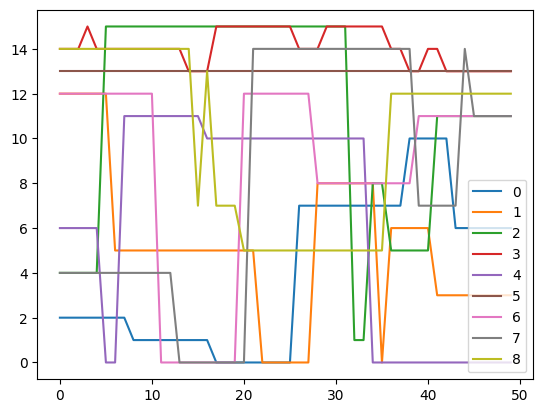

In [22]:
categoricals : torch.Tensor = model.encoder.get_categoricals(dataset[0]['observations'][None, ...].to(fabric.device))

catmax = categoricals.argmax(dim=-1).cpu()

ANALYSIS_DIM = [0, 1, 2, 3, 4, 5, 6, 7, 8]

print(f"Evolution of categories along dimensions {ANALYSIS_DIM}")
plt.plot(catmax[0, :, ANALYSIS_DIM])
plt.gca().legend(ANALYSIS_DIM)
plt.show()